In [366]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
from numpy import linalg as la

In [384]:

red_lower = np.asarray([170, 75, 100])
red_upper = np.asarray([180, 255, 255])

red_lower_l = np.asarray([0, 75, 100])
red_upper_l = np.asarray([10, 255, 255])

yellow_lower = np.asarray([23, 25, 100])
yellow_upper = np.asarray([29, 255, 255])

white_lower = np.asarray([0, 0, 100])
white_upper = np.asarray([255, 40, 255])

DISTANCE_OFFSET = 7
DEGREES_OFFSET = 0
DOUBLE_LINE_HEADING_OFFSET = 5

midpoint_lookdown = np.asarray([320, 150])
midpoint_lookahead = np.asarray([320, 80])
midpoint_initial = np.asarray([320, 330])

origin = np.asarray([0, 0])

    

def show(img):
    plt.imshow(img)
    plt.title(title)
    plt.show()
    
    
def crop_looking_down(img):
    h,w, c = img.shape
    return img[150:h-180, 0:w]

def crop_looking_ahead(img):
    h,w, c = img.shape
    return img[100:h-300, 0:w]

def crop_for_initialization(img):
    h,w, c = img.shape
    return img[150:h, 0:w]


def get_yellow_mask(hsv_img): #in HSV format
    
    mask_yellow = cv2.inRange(hsv_img, yellow_lower, yellow_upper)
    return mask_yellow

def get_white_mask(hsv_img): #in HSV format
    
    mask_white = cv2.inRange(hsv_img, white_lower, white_upper)
    return mask_white

def get_red_mask(hsv_img): #in HSV format
    
    mask_red = cv2.inRange(hsv_img, red_lower, red_upper)
    mask_red_l = cv2.inRange(hsv_img, red_lower_l, red_upper_l)
    red_mask = cv2.bitwise_or(mask_red, mask_red_l)
    return red_mask

def get_lane_mask(hsv_img): #in HSV format
    mask_yellow = get_yellow_mask(hsv_img)
    mask_white = get_white_mask(hsv_img)
    lane_mask = cv2.bitwise_or(mask_white, mask_yellow)
    return lane_mask
    
def get_lane_and_stop_mask(hsv_img):  #in HSV format
    stop_mask = get_red_mask(hsv_img)
    lane_mask = get_lane_mask(hsv_img)
    lane_and_stop = cv2.bitwise_or(stop_mask, lane_mask)
    return lane_and_stop

def get_masked_image(img, hsv_img):
    return cv2.bitwise_and(img,img, mask=get_lane_and_stop_mask(hsv_img))

def get_edges(hsv_img, color="yellow", blur=True):
    if color == "white":
        mask = get_white_mask(hsv_img)
    elif color == "yellow":
        mask = get_yellow_mask(hsv_img)
    elif color == "red":
        mask = get_red_mask(hsv_img)
    else:
        raise ValueError('Invalid color option for lane edges')

    if blur:
        mask = cv2.medianBlur(mask, 3)

    edges = cv2.Canny(mask, 200, 250)

    return edges


def preprocess(img):
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return crop_looking_down(hsv_image), crop_looking_ahead(hsv_image), crop_for_initialization(hsv_image)
    

In [459]:
def get_lines_in_image(edges):
    lines = cv2.HoughLinesP(edges, rho=1, theta=1 * np.pi / 180, threshold=35, minLineLength=75, maxLineGap=50)
    if lines is None:
        lines = cv2.HoughLinesP(edges, rho=1, theta=1 * np.pi / 180, threshold=35, minLineLength=70, maxLineGap=50)
    if lines is None:
        lines = []
    return lines

def show_lines_on_image(img, lines):
    temp_img=cv2.cvtColor(img.copy(), cv2.COLOR_HSV2RGB)
    for line in lines:
        if line is not None:
            x1, y1, x2, y2 = line[0]
            cv2.line(temp_img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    show(temp_img)

def slope(line):
    x1, y1, x2, y2 = line[0]
    return (y2-y1)/(x2-x1)
    

def get_closest_line(hsv_img, color, mode):
    edges = get_edges(hsv_img, color=color, blur=True)
    lines = filter_outlier_lines(get_lines_in_image(edges))
    

    closest_line = None
    min_dist = 500
    for line in lines:
        dist = get_distance_from_line(line, mode)
        if dist < min_dist:
            closest_line = line
            min_dist = dist
    return closest_line

def get_lane_lines(hsv_image, mode):
    yellow = get_closest_line(hsv_image, "yellow", mode)
    white = get_closest_line(hsv_image, "white", mode)
    red = get_closest_line(hsv_image, "red", mode)

    if (white is not None) and (yellow is not None) and (not is_yellow_to_left_of_white(yellow, white)):
        white = None

    return yellow, white, red

def get_distance_from_line(line, mode):
    x1, y1, x2, y2 = line[0]
    p1 = np.asarray([x1, y1])
    p2 = np.asarray([x2, y2])
    if mode == "lookahead":
        return np.around(np.abs(np.cross(p2 - p1,  p1 - midpoint_lookahead) / la.norm(p2 - p1)))
    elif mode == "lookdown":
        return np.around(np.abs(np.cross(p2 - p1,  p1 - midpoint_lookdown) / la.norm(p2 - p1)))
    elif mode == "initial":
        return np.around(np.abs(np.cross(p2 - p1,  p1 - midpoint_initial) / la.norm(p2 - p1)))
    else:
        raise ValueError("Invalid mode specified.")

# if both white and yellow are present, and if their slopes are same sign, yellow line needs to be closer to origin
# when initializing position, you might be in the other lane.

# so first anchor on yellow line, then see if there's a line on the other side of origin for this line

def is_yellow_to_left_of_white(yellow_line, white_line):
    o_x, o_y = origin
    x1, y1, x2, y2 = yellow_line[0]
    w_x1, w_y1, _ , _ = white_line[0]
    cross_origin = (x2 - x1)*(o_y - y1) - (y2 - y1)*(o_x - x1)
    cross_white = (x2 - x1)*(w_y1 - y1) - (y2 - y1)*(w_x1 - x1)
    return cross_origin*cross_white < 0

def get_d_est(yellow, white, mode):
    if yellow is not None and white is not None:
        d_est = (get_distance_from_line(yellow, mode) - get_distance_from_line(white, mode))/2
    elif white is not None:
        d_est = one_side_distance_offset(mode)-get_distance_from_line(white, mode)
    elif yellow is not None:
        d_est = get_distance_from_line(yellow, mode) - one_side_distance_offset(mode)
    else:
        return 0
    return d_est + DISTANCE_OFFSET

def one_side_distance_offset(mode):
    if mode == "lookdown":
        return 194
    if mode == "initial":
        return 350
    if mode == "lookahead":
        return 95


def get_heading(yellow, white):
    if (yellow is not None) and (white is not None):
        heading = np.degrees(np.arctan((slope(white) + slope(yellow)) / 2)) + DOUBLE_LINE_HEADING_OFFSET
    elif (yellow is not None) and slope(yellow) <= 0:
        heading = np.degrees(np.arctan(slope(yellow))) - 90 + DEGREES_OFFSET
    elif (yellow is not None) and slope(yellow) > 0:
        heading = np.degrees(np.arctan(slope(yellow))) + 90 - DEGREES_OFFSET
    elif (white is not None) and slope(white) <= 0:
        heading = 270 - np.degrees(np.arctan(slope(white))) + DEGREES_OFFSET
    elif (white is not None) and slope(white) > 0:
        heading = 90 - np.degrees(np.arctan(slope(white))) - DEGREES_OFFSET
    else:
        heading = 0  # if you can't see yellow or white, keep going straight
    return np.radians(np.around(heading))

def is_yellow_line_to_left_of_centre(yellow):
    x1, y1, x2, y2 = yellow[0]
    if y1>y2:
        return x1<320
    else:
        return x2<320

In [386]:
def get_steering(heading, d_est, state):
    if state == "initializing":
        k_p, k_d = 0.05, 2.5
    elif state == "in_lane":
        k_p, k_d = 0.125, 12.5
    return k_p*d_est + k_d*heading

In [409]:
import math 

def filter_outlier_lines(lines):
    if (lines is None) or len(lines) == 0 or len(lines) == 1:
        filtered_lines = lines

    elif len(lines) == 2:
        if get_length(lines[0]) > get_length(lines[1]):
            filtered_lines = [lines[0]]
        else:
            filtered_lines = [lines[1]]
    else:
        slopes = [np.around(np.degrees(np.arctan(slope(line)))) for line in lines]
        mean = np.mean(slopes)
        std = np.std(slopes)
        filtered_lines = [line for line in lines if (abs(mean - np.around(np.degrees(np.arctan(slope(line))))) <= 1.2*std)]

    return filtered_lines

def get_length(line):
    x1, y1, x2, y2 = line[0]
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)

In [464]:
def get_speed(steering):
    if abs(steering) < 5:
        speed = 1
    else:
        speed = math.exp(-abs(steering) / 25)
    return round(speed, 2)

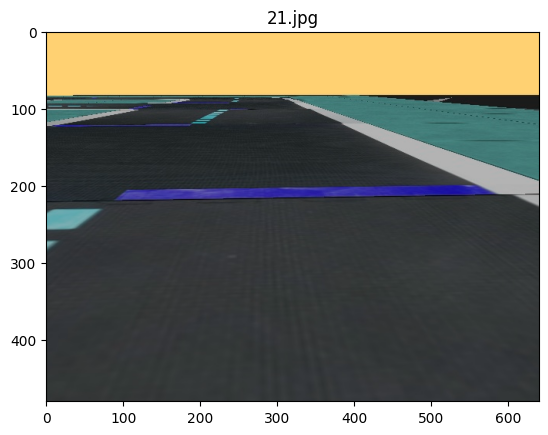

In [461]:
path = "observations_test"
title = "21.jpg"
img = cv2.imread(os.path.join(path, title))
show(img)

In [462]:
lookdown, lookahead, initial = preprocess(img)
image = lookdown
mode = "lookdown"
state = "in_lane" # "initializing"  "in_lane"

[[  0 133  70  82]] [[450   1 585  61]] [[ 92  68 419  63]]


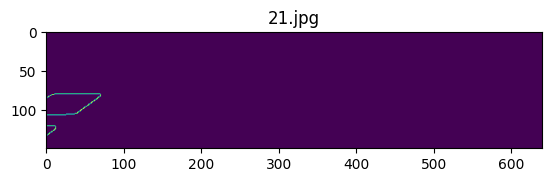

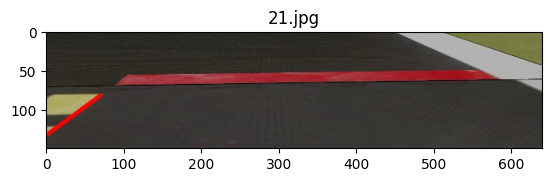

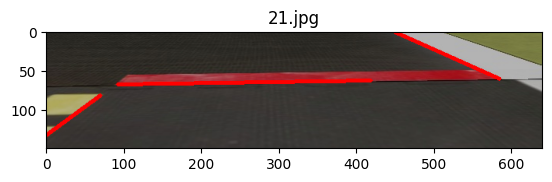

In [463]:
yellow, white, red = get_lane_lines(image, mode)
print(yellow, white, red)

edges = get_edges(image, color="yellow", blur=True)
lines = get_lines_in_image(edges)

show(edges)
show_lines_on_image(image, lines) 

show_lines_on_image(image, [yellow, white, red])

In [465]:
d_est = get_d_est(yellow, white, mode)
print("d_est = ", d_est)
heading = get_heading(yellow, white)
print("heading = ", heading, ", and in degrees = ", np.degrees(heading))

print(get_steering(heading, d_est, state))
print(get_speed(steering))

d_est =  13.5
heading =  -0.05235987755982989 , and in degrees =  -3.0000000000000004
1.0330015305021263


NameError: name 'steering' is not defined

In [458]:
print(np.degrees(np.arctan(slope(yellow))))
print(np.degrees(np.arctan(slope(white))))

print(get_distance_from_line(yellow, mode))
print(get_distance_from_line(white, mode))

#(get_distance_from_line(yellow, mode) - get_distance_from_line(white, mode))/2
np.degrees(np.arctan(slope(yellow))) - 90 + DEGREES_OFFSET
#get_distance_from_line(yellow, mode) - one_side_distance_offset(mode)

-36.0760115563686
23.962488974578182
202.0
189.0


-126.0760115563686

[[ 32 118 120  59]] -34.0 187.0


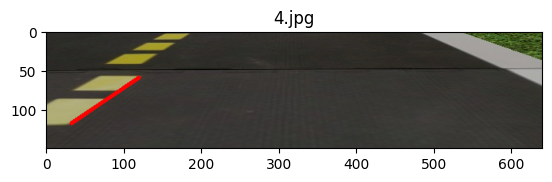

[[  0  93 171   2]] -28.0 201.0


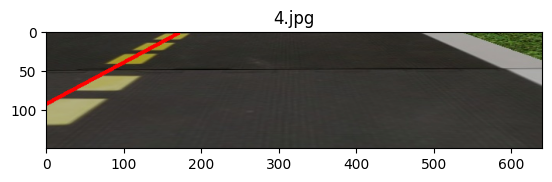

[[ 80  40 155   2]] -27.0 207.0


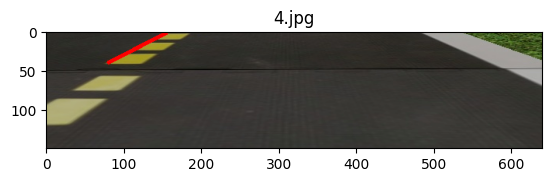

In [365]:
for line in lines:
#for line in filter_outlier_lines(lines):
    print(line, np.around(np.degrees(np.arctan(slope(line)))), get_distance_from_line(line, mode))
    show_lines_on_image(image, [line]) 

In [291]:
lines

array([[[ 42,  88, 188,   4]],

       [[ 31,  63, 162,   2]],

       [[  7,  88,  68,  88]]], dtype=int32)

In [451]:
def get_speed(steering):
    if abs(steering) < 2:
        speed = 1
    else:
        speed = math.exp(-abs(steering)/25)
    return speed

In [453]:
get_speed(2.5)

0.9048374180359595